https://www.kaggle.com/datasets/d4rklucif3r/restaurant-reviews

https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe


* ## Se añaden algunos hallazgos y sugerencias dados por el autor como son:

  * ## El uso de un diccionario para word2vec ya pre-entrenado, esto para lospuntos 3 y 4 que se necesitan de los requerimientos.

  * ## Para incrementar la sensibilidad del sentimiento, se ha propuesto conservar los elementos numéricos y convertirlos a textos, la explicación se encuentra en la sección pertinente pero el autor considera que es más sensible decir "me tardé veinte horas" a simplemente poner "me tardé horas". Por esta razón se usan bibliotecas (inflect, regex) y funcionalidades especiales para lograr este cometido.

* ## En lo que respecta a la red neuronal, se usa una arquitectura muy sencilla con una capa LSTM Unidireccional y una Dense que nos ayuda en la clasificación de sentimiento; sorprendentemente la arquitectura más simple es la más fuerte que se genera en este ejercicio (se anexan evidencias de otros ejemplos)

* ## Para la parte de evaluación del modelo, se ha optado por el uso del accuracy y la matrix de confusión para ver no sólo si se falló o no sino en qué.


# Paso 1: Exploración y Limpieza de los Datos.

### En esta operación, se hace un análisis de los textos y se generan las funcionalidades necesarias para hacer las transformaciones.



In [ ]:
#Dado que los textos en esta ocasión deben mantenerse lo más íntegros posible
#(sin stemming ni stop words ni lemmatización) Se propone conservar las partes
#numéricas a textos para preservar la mayor candtidad de texto.

#Para ello nos apoyamos de la biblioteca "Inflect"

#https://stackoverflow.com/questions/8982163/how-do-i-tell-python-to-convert-integers-into-words

#Véase la sección de la limpieza de los campos text.

#Aquí se instala la biblioteca.
!pip install inflect

## 1.2. Cargando bibliotecas y variables globales.

In [ ]:
#----------------------- BIBLIOTECAS DE PROPÓSITO GENERAL-----------------------
import numpy as np
import pandas as pd

#----------------------- BIBLIOTECAS DE VISUALIZACIÓN --------------------------
import seaborn as sns
import matplotlib.pyplot as plt

#----------------------- BIBLIOTECAS PARA EL MODELO WORD2VEC -------------------

#Para poder obtener las palabras únicas y con base en ésto, generar los
#diccionarios de índices, palabras.
from functools import reduce

#Para la transformación de GloVe a Word2Vec
import csv

#Para cargar las bibliotecas del modelo word2vec.
import gensim
from gensim.models.keyedvectors import KeyedVectors

#Para agregar los PAD_SEQUENCES.
from tensorflow.keras.preprocessing.sequence import pad_sequences

#----------------------- BIBLIOTECAS PARA LA RED NEURONAl ----------------------

#Para inicializar los pesos de la red.
from numpy.random import seed

#Para hacer las limpiezas de datos.
import re
import inflect

#Para guardar los modelos o las palabras en word2vec.
import pickle

#Para dividir los conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

#Se importan todas las funcionalidades de Tensorflow para la red neuronal
#recurrente.
import tensorflow

from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

#Para generar una matriz de confusión.
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.math import confusion_matrix

#---------------------- SECCIÓN PARA VARIABLES GLOBALES ------------------------

#Variable para el path de Google Drive.
google_drive_path = "/content/drive"

#------------------------------------------------------------------------------

#Nombre de la base de datos de opiniones.
reviews_file_path = "0.-WebinarProposal/Code/"

reviews_file_name = "customer_review.csv"

#Nombre de la base de datos con el formato GlovE
glove_file_name = "glove.840B.300d.txt"

#Nombre de la base de datos de las palabras word2vec
word2vec_file_name = "word2vec.840B.300d.txt"

#------------------------------------------------------------------------------

#Nombre del diccionario de palabras únicas de las RESEÑAS.
dictionary_of_reviews_file_name = "dic_reviews_text.pkl"

#Nombre del archivo de palabras a índices.
word_to_index_file_name = "word_to_index.pkl"

#Nombre del archivo de índices a palabras.
index_to_word_file_name = "index_to_word.pkl"

#------------------------------------------------------------------------------

#Variable para guardar los diccionarios de palabras con pesos
#QUE SÓLO APARECEN EN LAS RESEÑAS.
dictionary_words_with_weights_file_name = "dic_tokens_reviews_w2v.pkl"

#Variable para guardar las palabras que no tienen alguna aparición
#en el modelo Word2Vec.
words_without_embedding_file_name = "words_without_embedding.pkl"

#Para guardar los pesos de la red neuronal recurrente.
neural_network_weights_file_name = "sentiment_classification_weights"

#------------------------------------------------------------------------------

#Se inicializa el objeto para convertir de números a textos.
p = inflect.engine()

#Para poder hacer algunas limpiezas numéricas, se hace uso de expresiones
#regulares (para detectar los patrones).
#https://stackoverflow.com/questions/8586346/python-regex-for-integer
RE_INT = re.compile(r'^[1-9]\d*|0$')

#Con esta variable se evita el sobreajuste en las redes neuronales.
#Es parte del requisito para la práctica.
dropout_value = 0.20

#Con estas variables se hacen los rastreos de información cuando se convierten
#las palabras a un índice numérico y viceversa.
word_to_index = {}
index_to_word = {}

## 1.3. Cargando la base de datos de reseñas.

####  A continuación se carga la base de RESEÑAS que es independiente al modelo word2vec.

#### <b> Importante: es necesario que la base de datos se haya guardado como acceso directo previamente, de lo contrario, no funcionará este notebook. </b>

In [ ]:
from google.colab import drive
drive.mount(google_drive_path)

Mounted at /content/drive


In [ ]:
#Leyendo el dataframe y ver qué contiene.
df = pd.read_csv(google_drive_path + "/MyDrive/" + reviews_file_path + reviews_file_name)

In [ ]:
#Obteniendo las dimensiones de la base.
df.shape

#------ RESULTADO --------
#La base consta de 1032476 reseñas y 2 columnas.
#A continuación se ven los elementos más a detalle.

(1032476, 2)

In [ ]:
df.head(20)

#------ RESULTADO --------
#Se puede apreciar que se tienen los comentarios así como variables descriptivas en torno al
#comentario como si es de "confianza" (deceptive), el hotel al que fueron destinados
#los comentarios, la polaridad (sentimiento) del comentario y la fuente.

,flag,text
0,1,I did something wrong when I ordered the room...
1,0,Bar service
2,1,Great location and had all the creature comfo...
3,0,Can t think of anything we didn t like
4,1,Price and Location though it was a challenge ...
5,0,bathroom and sleeping are conntected with a d...
6,1,nice place clean new hotel
7,0,No Negative
8,0,Bed too hard breakfast too expensive
9,0,No Negative


In [ ]:
#Revisar si hay nulos en alguna de las columnas que necesitamos.
#https://datatofish.com/check-nan-pandas-dataframe/

for current_column in df.columns:
    print("Revisando si {0} tiene nulos: ".format(current_column))
    print("   Conteo de nulos: ", df[current_column].isnull().sum())

#------ RESULTADO --------
#Como se puede apreciar, no existe ningún valor nulo en ninguna de las columnas.
#Entonces se omite la parte de alguna posible imputación o limpieza de este tipo.

Revisando si flag tiene nulos: 
   Conteo de nulos:  0
Revisando si text tiene nulos: 
   Conteo de nulos:  0


In [ ]:
#De igual manera se asigna la variable predictiva que, como se ha mencionado,
#es "Polarity".
predictive_variable = "flag"

In [ ]:
#Se imprime el resultado de la transformación ANTES DE LA ELMINACIÓN DE TEXTOS
#innecesarios.
print(df[predictive_variable].value_counts())

flag
1    516238
0    516238
Name: count, dtype: int64


In [ ]:
#Se eliminan los textos innecesarios (los que tienen 2 palabras o menos)
#Esto por la construcción de una oración: sujeto + verbo + predicado (3 elementos)

df["splitted_text"] = df["text"].apply(lambda x: x.strip())
df["splitted_text"] = df["splitted_text"].str.split(' ', expand=False)
df = df[df["splitted_text"].str.len() > 3]
df = df.drop('splitted_text', axis=1)


In [ ]:
#Se imprime el resultado de la transformación DESPUES DE LA ELIMINACIÓN DE LOS
#TEXTOS INNECESARIOS.
print(df[predictive_variable].value_counts())

flag
1    405449
0    325413
Name: count, dtype: int64


In [ ]:
#En esta operación se hace la limpieza de los TEXTOS (RESEÑAS), en particular
#cada texto se transforma en una lista de tokens limpios que sirvan para el
#cálculo de los PAD_Tokens y como insumo de la red neuronal.

#Al explorar la base de datos se halló oraciones como:

# -> "I arrived at 2 am"
# -> "It costed me 3 dollars"
# -> "I waited for 10 houes"

#Entonces, esto como propuesta por parte del autor, es posible conservar los
#números y pasarlos a texto con la finalidad de preservar la sensibilidad del
#comentario pues el uso de cuantificadores, incluso con textos, puede intensificar.
#más "el sentimiento".


#Fuentes de consulta para esta función
#Ver cuáles textos contienen números o caracteres raros y tratar de limpiarlos.
#https://stackabuse.com/how-to-split-string-on-multiple-delimiters-in-python/
#https://www.techiedelight.com/remove-non-alphanumeric-characters-string-python/

def transform_review(review):

    #Aquí se guardan los tokens limpios.
    list_review_final = []

    #Se reemplaza todos los caracteres extraños por espacios en blanco.
    replaced_review = re.sub(r'\W+', ' ', review)

    #La tokenización se hace por los espacios en blanco.
    list_replaced_review = replaced_review.split(" ")

    #Por cada token se hace esto.
    for element in list_replaced_review:

        transformed_generic_list = []

        #Si el token coincide con un número identificado por medio
        #de una expresión regular, se hace la transformación.
        if RE_INT.match(element):

           transformed_number = p.number_to_words(element)

           #Dividiendo elemento por varios separadores.
           list_transformed_number = re.split(',|;|-| ', transformed_number)

           #Puede haber el caso de números compuestos, entonces se hace el
           #tratamiento por cada uno.
           for current_transformed_number in list_transformed_number:
               transformed_generic_list.append(current_transformed_number)

        #Si el token es una palabra, sólo se hace la limpieza a lower.
        else:
            transformed_generic_list.append(element.lower())

        #Al final todos los elementos se agregan a la lista final.
        for generic_element in transformed_generic_list:
            if generic_element != "":
               list_review_final.append(generic_element)

    return list_review_final


#Aquí se adjuntan sólo unas muestras para que se denote su transformación a número
#con texto.
string_example_1 = "Just got back from a 24:35 hour flight up in Chicago shopping"
string_example_2 = "Just got back from a 242335456 cost flight up in Chicago shopping"

print("Example 1 transformed: ",transform_review(string_example_1))
print("Example 2 transformed: ",transform_review(string_example_2))

Example 1 transformed:  ['just', 'got', 'back', 'from', 'a', 'twenty', 'four', 'thirty', 'five', 'hour', 'flight', 'up', 'in', 'chicago', 'shopping']
Example 2 transformed:  ['just', 'got', 'back', 'from', 'a', 'two', 'hundred', 'and', 'forty', 'two', 'million', 'three', 'hundred', 'and', 'thirty', 'five', 'thousand', 'four', 'hundred', 'and', 'fifty', 'six', 'cost', 'flight', 'up', 'in', 'chicago', 'shopping']


In [ ]:
#Se hace la división entre conjuntos de entrenamiento y prueba
#tanto para los descriptores como la variable predictiva.

Y = df[predictive_variable]
X = df.drop(predictive_variable, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = dropout_value, shuffle = True, random_state = 0)

In [ ]:
#Para poder obtener las palabras únicas del texto, se hace aplica la transformación
#previamente implementada.

X_train["tokenized_text"] = X_train["text"].apply(lambda x: transform_review(x))

In [ ]:
#Se guarda una copia para hacer operaciones de investigación.
X_temp = X_train.copy()

Axes(0.125,0.11;0.775x0.77)


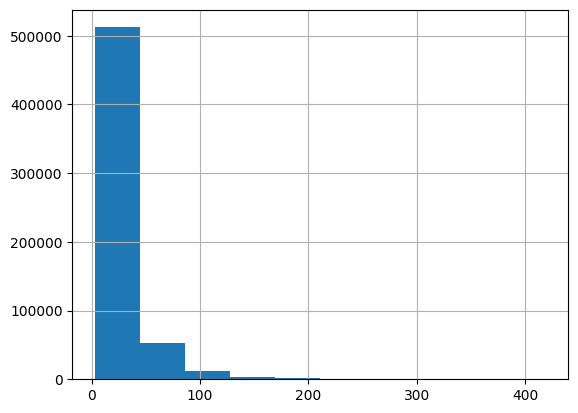

In [ ]:
#Aprovechando el conjunto de datos ya tokenizados, se hace el cálculo del texto
#con longitud más larga EN EL CONJUNTO DE ENTRENAMIENTO para que se puedan añadir
#los TOKEN_PADS de los requisitos.

#Calcular la longitud más grande de la oración (fuente de consulta)
#https://www.geeksforgeeks.org/find-maximum-values-position-in-columns-and-rows-of-a-dataframe-in-pandas/
X_temp["length_sentence"] = X_temp["tokenized_text"].apply(lambda x: len(x))


#A continuación se imprime el histograma para que se pueda hacer un corte en la
#oración más larga.
print(X_temp["length_sentence"].hist())

In [ ]:
#Replicando el ejercicio en clase, se puede ver que la longitud de las oraciones
#tienen una distribución orientada a la izquierda, por lo que al igual que en
#la clase, se obtendra la longitud que represente al 99.75% de las oraciones.

max_pad_sequence  = int(X_temp["length_sentence"].quantile(0.9975))
print("El número máximo de palabras en una oración es: ", max_pad_sequence)

El número máximo de palabras en una oración es:  227


<b> Importante: a partir de este momento, se trabaja sólo con el conjunto de entrenamiento en el sentido en que, aunque el conjunto de datos en general parece ser independiente, se simula un escenario en el que NO se conoce la parte de TESTING y sólo se aplicarán las respectivas transformaciones en éste hasta la sección del modelo (PASO 2). </b>

In [ ]:
#Para obtener las palabras únicas del texto, se hace una transformación especial
#en la que todos los elementos tokenizados del paso anterior se pasan a un set.

#Éste, al ser un filtro natural, deja sólo los elementos únicos.

#https://stackoverflow.com/questions/41955006/how-to-take-set-union-of-all-the-values-in-a-column-of-pandas-dataframe

X_train["text_with_set"] = X_train["tokenized_text"].apply(lambda x: set(x))

set_of_unique_words = reduce(set.union, X_train["text_with_set"])


#Aquí, con la ayuda del set, se generan los diccionarios para word_to_index
# e index_to_word.

counter = 1

#IMPORTANTE: Aquí se genera ya el caso del PAD_token para ambos diccionarios.
word_to_index['PAD_token'] = 0
index_to_word[0] = 'PAD_token'

#Con la información de los elementos únicos, se generan los diccionarios.
for element in set_of_unique_words:
    word_to_index[element] = counter
    index_to_word[counter] = element
    counter += 1

In [ ]:
#Aquí se muestran los 3 "tipos" de textos:
# Original.
# Tokenizado.
# Set con palabras irrepetibles.
X_train

,text,tokenized_text,text_with_set
1753,No water pressure Breakfast was rather sad th...,"[no, water, pressure, breakfast, was, rather, ...","{no, was, dried, water, breakfast, pressure, t..."
219507,Breakfast noisy with children,"[breakfast, noisy, with, children]","{children, with, noisy, breakfast}"
383519,cleaning was not good When we were back the r...,"[cleaning, was, not, good, when, we, were, bac...","{on, was, we, and, were, the, door, cleaning, ..."
770201,Room 617 junior suite was directly below a di...,"[room, six, hundred, and, seventeen, junior, s...","{on, insisted, directly, staff, front, junior,..."
961557,Clean well run hotel near South Kensington mu...,"[clean, well, run, hotel, near, south, kensing...","{kensington, staff, near, well, run, shopping,..."
...,...,...,...
508341,Bathroom a bit tired looking and small,"[bathroom, a, bit, tired, looking, and, small]","{and, a, small, bathroom, bit, looking, tired}"
215033,Very nice staff very central and overall hote...,"[very, nice, staff, very, central, and, overal...","{staff, upgraded, well, very, overall, has, ho..."
166253,Empty area without any big chances for good m...,"[empty, area, without, any, big, chances, for,...","{some, chances, for, foods, big, available, br..."
615721,Everything I love the Langham its amazing Bea...,"[everything, i, love, the, langham, its, amazi...","{staff, well, god, up, coming, to, i, and, is,..."


In [ ]:
#Guardando la lista de palabras únicas del entrenamiento y los conjuntos
#index_to_word y word_to_index en un pickle, CADA UNO POR SEPARADO.

pickle.dump(set_of_unique_words, open (google_drive_path + "/MyDrive/" + reviews_file_path + dictionary_of_reviews_file_name, 'wb'))
pickle.dump(word_to_index, open (google_drive_path + "/MyDrive/" + reviews_file_path + word_to_index_file_name, 'wb'))
pickle.dump(index_to_word, open (google_drive_path + "/MyDrive/" + reviews_file_path + index_to_word_file_name, 'wb'))

In [ ]:
#Ahora, dado que el modelo requiere que todos los textos se conviertan en números,
#se aplica la siguiente función

def transform_words_to_index(word_list):

    final_list = []

    #Por cada elemento, se hace la transformación numérica y se genera una lista
    #que será la que contenga los índices de las palabras.
    for current_word in word_list:

        try:
           final_list.append(word_to_index[current_word])

        except:
          pass


    return final_list

In [ ]:
#Se hace la aplicación de la conversión texto a número.
X_train["text"] = X_train["tokenized_text"].apply(lambda x: transform_words_to_index(x))

In [ ]:
#Imprimimos los 3 tipos de "textos"
X_train

,text,tokenized_text,text_with_set
1753,"[47110, 65043, 61174, 64402, 56512, 24185, 236...","[no, water, pressure, breakfast, was, rather, ...","{no, was, dried, water, breakfast, pressure, t..."
219507,"[64402, 19634, 43062, 20472]","[breakfast, noisy, with, children]","{children, with, noisy, breakfast}"
383519,"[2560, 56512, 298, 39240, 21626, 68173, 61979,...","[cleaning, was, not, good, when, we, were, bac...","{on, was, we, and, were, the, door, cleaning, ..."
770201,"[20962, 35529, 23066, 4483, 35166, 53263, 3673...","[room, six, hundred, and, seventeen, junior, s...","{on, insisted, directly, staff, front, junior,..."
961557,"[16859, 31548, 38876, 13696, 59047, 18959, 223...","[clean, well, run, hotel, near, south, kensing...","{kensington, staff, near, well, run, shopping,..."
...,...,...,...
508341,"[26263, 19342, 64965, 4829, 1642, 4483, 24708]","[bathroom, a, bit, tired, looking, and, small]","{and, a, small, bathroom, bit, looking, tired}"
215033,"[66028, 40832, 18597, 66028, 48947, 4483, 1052...","[very, nice, staff, very, central, and, overal...","{staff, upgraded, well, very, overall, has, ho..."
166253,"[62937, 55123, 62773, 61792, 13689, 15169, 299...","[empty, area, without, any, big, chances, for,...","{some, chances, for, foods, big, available, br..."
615721,"[22114, 49119, 54052, 47192, 1352, 64725, 2784...","[everything, i, love, the, langham, its, amazi...","{staff, well, god, up, coming, to, i, and, is,..."


In [ ]:
#A continuación se aplica el pad_sequence con parámetro PRE, esto de acuerdo con
#los lineamientos de la tarea.

#(Esta liga nos dice que pad_sequences SÍ REGRESA UN ARRAY)
#https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do

#El valor maxlen es el que se obtuvo previamente al analizar la distribución
#de las longitudes de los textos.
X_train = pad_sequences(X_train["text"], padding='pre', maxlen=max_pad_sequence)

X_train

array([[    0,     0,     0, ..., 45505, 39352, 25840],
       [    0,     0,     0, ..., 19634, 43062, 20472],
       [    0,     0,     0, ..., 36305, 47192, 48675],
       ...,
       [    0,     0,     0, ..., 20425, 12509, 38900],
       [    0,     0,     0, ..., 14464, 45476, 34759],
       [    0,     0,     0, ..., 52707, 56512, 52675]], dtype=int32)

## 1.4. La variable predictiva

#### Aquí sólo se hace una revisión inicial de la variable predictiva, el resto se hace hasta la generación del modelo (PASO 2).

In [ ]:
#Sólo verificamos que la variable predictiva, ya que no tiene nulos,
#esté balanceada.

y_train.value_counts(normalize=True)

#------ RESULTADO --------
#Como se puede apreciar, estamos hablando de una distribución casi balanceada pero
#muy útil para poder continuar con los procedimientos.

flag
1    0.554452
0    0.445548
Name: proportion, dtype: float64

## 1.5. Sobre el modelo WORD2VEC.

#### Una de las sugerencias del autor más relevantes tiene que ver con el modelo WORD2VEC; de acuerdo con los puntos 3 y 4 se debe hacer una vectorización del texto y obtener la matriz de vectores.

#### La propuesta del autor consiste en usar un conjunto de datos pre-entrenado para el idioma inglés (tomando como base el idioma en el que se encuentran escritas las reseñas en la sección anterior).

####  Directamente no hay vectorizaciones en inglés en formato WORD2VEC, así que, después de numerosas investigaciones, se dio con el formato GloVe (Global Vectorization).

* # https://nlp.stanford.edu/projects/glove/
* # https://radimrehurek.com/gensim/scripts/glove2word2vec.html

#### En particular, se halló este archivo (2.2 millones de palabras, con vectores de 300 palabras por cada una):

# <center> https://nlp.stanford.edu/data/glove.840B.300d.zip </center>

#### En teoría sólo se necesita convertir el formato GloVe a Word2Vec pero aquí es donde se hace un esfuerzo considerable ya que se debe hacer una preparación de formatos y codificaciones, en particular estos sitios contienen todo lo necesario:

# <center> https://stackoverflow.com/questions/46297740/how-to-turn-embeddings-loaded-in-a-pandas-dataframe-into-a-gensim-model </center>

#### De esta manera, si se desea hacer la conversión de dichos formatos, sépase que Colab no va a aguantar esta operación, por lo que se ofrece un 2o. notebook (ConversionFormats) que debe ejecutarse en local.



## 1.6. Cargando el modelo WORD2VEC.

#### Ahora se carga el modelo word2vec con las transformaciones incluídas del paso anterior, de igual manera se hacen algunas operaciones de similitud del coseno y otros ejercicios para comprobar que funciona.

#### Importante: es necesario que la base de datos se haya guardado como acceso directo previamente, de lo contrario, no funcionará este notebook.


In [ ]:
#Se carga la base de datos ya en su formato word2vec.
#La base NO es binaria, por lo que se pone su valor a "False".

w2v = KeyedVectors.load_word2vec_format(google_drive_path + "/MyDrive/" + reviews_file_path + word2vec_file_name, binary=False)

In [ ]:
#Se toma la función vista en clase para calcular la similitud coseno.

def similitud_coseno(a_vector, b_vector):
    '''Calcula la similitud coseno entre los vectores a y b'''

    numerador = np.dot(a_vector, b_vector)

    a_norm = np.sqrt(np.sum(a_vector**2))
    b_norm = np.sqrt(np.sum(b_vector**2))

    denominador = a_norm * b_norm

    similitud_coseno = numerador / denominador

    return similitud_coseno

In [ ]:
#Primer ejercicio: ver la similaridad ente dos palabras usando el método
#por defecto y el creado de manera "casera" para

word_1 = "house"
word_2 = "this"

print("La similaridad ({0},{1}) por EL MÉTODO POR DEFECTO es: ".format(word_1,word_2), w2v.similarity(word_1, word_2))
print("La similaridad ({0},{1}) por EL MÉTODO CASERO es: ".format(word_1,word_2), similitud_coseno(w2v[word_1], w2v[word_2]))


#------ RESULTADO --------
#En efecto, se llega a los mismos resultados.

La similaridad (house,this) por EL MÉTODO POR DEFECTO es:  0.34631044
La similaridad (house,this) por EL MÉTODO CASERO es:  0.3463104


In [ ]:
#Esta es la función casera generada en clase para poder obtener las palabras
#más parecidas a una referencia dada.

def encuentra_palabras_parecidas(palabra, n):
    #Se obtiene la lista con todas las palabras.
    vocabulario = w2v.index_to_key

    palabra = palabra.lower()
    palabra_vector = w2v[palabra]

    max_similitud = -1 # la inicializamos con una similaridad alejada
    mas_parecida = None

    similaridad = {}

    for p in vocabulario:

        try:
           similaridad[p] = similitud_coseno(palabra_vector,w2v[p])

        except:
           #Aquí hay algún elemento del word2vec que sale None y por lo mismo
           #su similaridad del coseno no existe. Para esos casos simplemente se remueven.
           pass
           #print(p)


    similaridad_ordenada = {k:v for k,v in sorted(similaridad.items(),
                                                  key=lambda x: x[1],
                                                 reverse=True)}
    lista_palabras = list(similaridad_ordenada.keys())

    return lista_palabras[1:n+1]


#encuentra_palabras_parecidas('dog',10)

In [ ]:
#Segundo ejercicio: ver cuáles son las palabras más cercanas a una dada como parámetro.

word_most_similar = "dog"

print("Las palabras más cercanas a {0} USANDO EL MÉTODO POR DEFECTO son: ".format(word_most_similar))
print(w2v.most_similar(word_most_similar))

print("--------------------------------------------")

print("Las palabras más cercanas a {0} USANDO EL MÉTODO CASERO son: ".format(word_most_similar))
print(encuentra_palabras_parecidas(word_most_similar,10))

#------ RESULTADO --------
#En efecto, se llega a los mismos resultados.

Las palabras más cercanas a dog USANDO EL MÉTODO POR DEFECTO son: 


/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


[('dogs', 0.8835931420326233), ('puppy', 0.8585214614868164), ('pet', 0.8057452440261841), ('cat', 0.8016855120658875), ('puppies', 0.7517312169075012), ('canine', 0.7349317669868469), ('pup', 0.7281187772750854), ('cats', 0.720764696598053), ('Dog', 0.7140929102897644), ('terrier', 0.7088441848754883)]
--------------------------------------------
Las palabras más cercanas a dog USANDO EL MÉTODO CASERO son: 
['dogs', 'puppy', 'pet', 'cat', 'puppies', 'canine', 'pup', 'cats', 'Dog', 'terrier']


## 1.7. Guardando los elementos más relevantes de Word2Vec.

#### En esta sección se guardan sólo los vectores de las palabras que aparecen en las reseñas del conjunto de ENTRENAMIENTO.

In [ ]:
#Se generan estas dos variables para guardar las palabras con pesos
#que aparecen en las reseñas, así como las que no se pudieron hallar.
dic_tokens_word2vec  = {}
palabras_sin_embedding =[]

#Se recorre el set de palabras únicas.
for token in set_of_unique_words:
    try:
     dic_tokens_word2vec[token] = w2v[token]
    except:
     palabras_sin_embedding.append(token)

In [ ]:
#En este caso, sólo para tener certeza de las palabras que se pudieron hallar, se
#imprime el tamaño del vector palabras_sin_embedding.

print("El número de palabras de las RESEÑAS que NO se encontraron en Word2vec: ", len(palabras_sin_embedding))
print("El número de palabras totales de las RESEÑAS: ", len(set_of_unique_words))


#------ RESULTADO --------
#Lo anterior significa que 174 palabras de 8507 no se encontraron, lo que representa
#un 2 por ciento. Considerando que la base contiene 2 millones de palabras, significa
#que puede mejorarse pero el número no es tan alarmante.

El número de palabras de las RESEÑAS que NO se encontraron en Word2vec:  20265
El número de palabras totales de las RESEÑAS:  68305


In [ ]:
#Sólo para corroborar, se hace una revisión más a detalle de las 174 palabras
# que no se ajustaron al modelo word2vec.
print(palabras_sin_embedding)


#------ RESULTADO --------
#Parece ser que son palabras con errores como "conplaint" en vez de "complaint"
#Entonces se procede con este diccionario ya que es seguro.

['planket', 'dhjafar', 'kkeping', 'ellese', 'mybloomsbury', 'maryleborne', 'douve', 'bedsize', 'chemps', 'veryou', 'abandonated', 'dinstance', 'resepsiyon', 'espicial', 'nothingo', 'mentens', 'reasonbale', 'considion', 'evvvvveeeeeerrrr', 'bartold', 'overpricec', 'pavlo', 'albazar', 'evethough', 'desappointed', 'serwisant', 'restoraunt', 'immidietely', 'dissaponited', 'proximatey', 'shoppingspree', 'diffefent', 'agrasif', 'tatayana', 'nussdorfer', 'kaspers', 'esprcially', 'roomupgrade', 'saop', 'ohla', 'kawthar', 'galibaldi', 'disaperd', 'garabaldi', 'mineraru', 'subherb', 'neiboughood', 'hrlpful', 'balmoaga', 'constructionworks', 'experoence', 'montserratt', 'reviewsabout', 'centtale', 'ttegod', 'magdeleue', 'lazaire', 'teleferic', 'complimantery', 'enthusatic', 'everythinks', 'cafatiere', 'freakingggg', 'ocate', 'leshalles', 'tuvett', 'maknoun', 'illfitting', 'deecember', 'bitterballin', 'votivkirche', 'bathhroom', 'undergaround', 'lagter', 'katchup', 'alellouiaaaa', 'poold', 'connec

In [ ]:
#Para concluir, se guardan en formato pickle tanto el diccionario de palabras con pesos
#tomados de las RESEÑAS DEL CONJUNTO DE ENTRENAMIENTO, como la lista de palabras sin embedding.

pickle.dump(dic_tokens_word2vec, open (google_drive_path + "/MyDrive/" + reviews_file_path + dictionary_words_with_weights_file_name, 'wb'))
pickle.dump(palabras_sin_embedding, open (google_drive_path + "/MyDrive/" + reviews_file_path + words_without_embedding_file_name, 'wb'))

In [ ]:
pd.DataFrame(X_train).to_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "X_train.csv", index = False)
pd.DataFrame(X_test).to_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "X_test.csv", index = False)
pd.DataFrame(y_train).to_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "y_train.csv", index = False)
pd.DataFrame(y_test).to_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "y_test.csv", index = False)

# Paso 2: Generación de la Red Neuronal Recurrente.

### En esta etapa, se lleva a cabo la limpieza final para los conjuntos de ENTRENAMIENTO y PRUEBA, así como la justificación del tipo de red implementada y la consecuente evaluación


## 2.1 Cargando los diccionarios finales (en caso de que se quiera comenzar el proceso desde este punto)

In [ ]:
#En esta operación se hace la limpieza de los TEXTOS (RESEÑAS), en particular
#cada texto se transforma en una lista de tokens limpios que sirvan para el
#cálculo de los PAD_Tokens y como insumo de la red neuronal.

#Al explorar la base de datos se halló oraciones como:

# -> "I arrived at 2 am"
# -> "It costed me 3 dollars"
# -> "I waited for 10 houes"

#Entonces, esto como propuesta por parte del autor, es posible conservar los
#números y pasarlos a texto con la finalidad de preservar la sensibilidad del
#comentario pues el uso de cuantificadores, incluso con textos, puede intensificar.
#más "el sentimiento".


#Fuentes de consulta para esta función
#Ver cuáles textos contienen números o caracteres raros y tratar de limpiarlos.
#https://stackabuse.com/how-to-split-string-on-multiple-delimiters-in-python/
#https://www.techiedelight.com/remove-non-alphanumeric-characters-string-python/

def transform_review(review):

    #Aquí se guardan los tokens limpios.
    list_review_final = []

    #Se reemplaza todos los caracteres extraños por espacios en blanco.
    replaced_review = re.sub(r'\W+', ' ', review)

    #La tokenización se hace por los espacios en blanco.
    list_replaced_review = replaced_review.split(" ")

    #Por cada token se hace esto.
    for element in list_replaced_review:

        transformed_generic_list = []

        #Si el token coincide con un número identificado por medio
        #de una expresión regular, se hace la transformación.
        if RE_INT.match(element):

           transformed_number = p.number_to_words(element)

           #Dividiendo elemento por varios separadores.
           list_transformed_number = re.split(',|;|-| ', transformed_number)

           #Puede haber el caso de números compuestos, entonces se hace el
           #tratamiento por cada uno.
           for current_transformed_number in list_transformed_number:
               transformed_generic_list.append(current_transformed_number)

        #Si el token es una palabra, sólo se hace la limpieza a lower.
        else:
            transformed_generic_list.append(element.lower())

        #Al final todos los elementos se agregan a la lista final.
        for generic_element in transformed_generic_list:
            if generic_element != "":
               list_review_final.append(generic_element)

    return list_review_final


#Aquí se adjuntan sólo unas muestras para que se denote su transformación a número
#con texto.
string_example_1 = "Just got back from a 24:35 hour flight up in Chicago shopping"
string_example_2 = "Just got back from a 242335456 cost flight up in Chicago shopping"

print("Example 1 transformed: ",transform_review(string_example_1))
print("Example 2 transformed: ",transform_review(string_example_2))

Example 1 transformed:  ['just', 'got', 'back', 'from', 'a', 'twenty', 'four', 'thirty', 'five', 'hour', 'flight', 'up', 'in', 'chicago', 'shopping']
Example 2 transformed:  ['just', 'got', 'back', 'from', 'a', 'two', 'hundred', 'and', 'forty', 'two', 'million', 'three', 'hundred', 'and', 'thirty', 'five', 'thousand', 'four', 'hundred', 'and', 'fifty', 'six', 'cost', 'flight', 'up', 'in', 'chicago', 'shopping']


In [ ]:
#Ahora, dado que el modelo requiere que todos los textos se conviertan en números,
#se aplica la siguiente función

def transform_words_to_index(word_list):

    final_list = []

    #Por cada elemento, se hace la transformación numérica y se genera una lista
    #que será la que contenga los índices de las palabras.
    for current_word in word_list:

        try:
           final_list.append(word_to_index[current_word])

        except:
          pass


    return final_list

In [ ]:
max_pad_sequence = 227

In [ ]:
X_train = pd.read_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "X_train.csv")

X_test = pd.read_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "X_test.csv")

y_train = pd.read_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "y_train.csv")

y_test = pd.read_csv(google_drive_path + "/MyDrive/" + reviews_file_path + "y_test.csv")

#Se carga el conjunto de palabras únicas de las RESEÑAS ya limpias.
set_of_unique_words = pickle.load( open(google_drive_path + "/MyDrive/" + reviews_file_path + dictionary_of_reviews_file_name, 'rb'))

#Se carga el diccionario de palabras word_to_index
word_to_index = pickle.load( open(google_drive_path + "/MyDrive/" + reviews_file_path + word_to_index_file_name, 'rb'))

#Se carga el diccionario de palabras index to word.
index_to_word = pickle.load( open(google_drive_path + "/MyDrive/" + reviews_file_path + index_to_word_file_name, 'rb'))

#Se carga el diccionario de palabras de las RESEÑAS con sus pesos como parte
#del modelo Word2Vec.
dic_tokens_word2vec = pickle.load( open(google_drive_path + "/MyDrive/" + reviews_file_path + dictionary_words_with_weights_file_name, 'rb'))

#Se carga la lista de palabras sin embedding.
palabras_sin_embedding = pickle.load( open(google_drive_path + "/MyDrive/" + reviews_file_path + words_without_embedding_file_name, 'rb'))

Para este paso se hacen las mismas transformaciones en los conjuntos de prueba que lo que se hizo en el entrenamiento, de igual forma se hace un análisis de las distribuciones de ambos conjuntos para poder validar que éstos vienen de la misma distribución.

In [ ]:
#Poner las distribuciones del ongitud de los textos y la variable predictiva.
#X_test2 = X_test.copy()

X_test["text"] = X_test["text"].apply(lambda x: transform_review(x))

#Para hacer los análisis de distribución.
X2_temp = X_test.copy()

X_test["text"] = X_test["text"].apply(lambda x: transform_words_to_index(x))
X_test= pad_sequences(X_test["text"], padding='pre', maxlen = max_pad_sequence)

In [ ]:
#Sólo para verificar, se imprimen los valores del conjunto de prueba.
print(X_test)

#------ RESULTADO --------
#Es importante señalar que ya se añadieron los PAD_tokens (con valor 0)
#que están al inicio de cada oración para completar el rango requerido.

[[    0     0     0 ... 18597 39240 64402]
 [    0     0     0 ... 61848 55003 25068]
 [    0     0     0 ... 18597 61979 49567]
 ...
 [    0     0     0 ... 15771 46869 28900]
 [    0     0     0 ... 10380  4925 27069]
 [    0     0     0 ... 33293 40832 20962]]


In [ ]:
#Se hacen los conteos de longitud en el conjunto de prueba.
X2_temp["length_sentence"] = X2_temp["text"].apply(lambda x: len(x))

#Ahora se hacen los análisis de distribución entre el conjunto de entrenamiento
#y el de prueba.
#Imprimiendo la distribución en el entrenamiento.
#print(X_temp["length_sentence"].hist())

Axes(0.125,0.11;0.775x0.77)


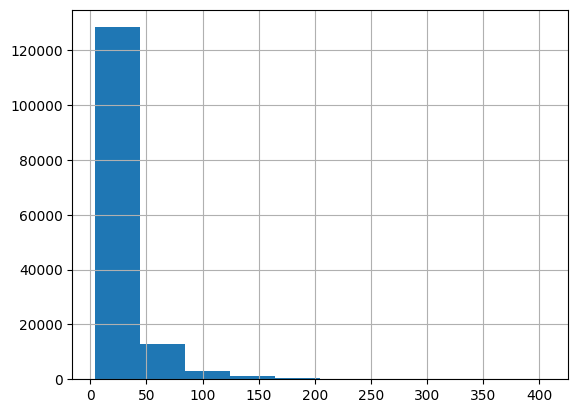

In [ ]:
#Imprimiendo la distribución en la prueba.
print(X2_temp["length_sentence"].hist())

#------ RESULTADO --------
#Se puede notar que las distribuciones son muy parecidas, incluso si en el caso
#de la distribución de la prueba los elementos a la derecha son más notorios, éstos
#no representan ningún problema debido al corte que se hace para el pad_sequence.

In [ ]:
#Ahora se imprimen los porcentajes de las clasificaciones tanto para el conjunto de entrenamiento
# como el de prueba.
print("Porcentajes del conjunto de entrenamiento: ")
print(y_train.value_counts(normalize = True))
print(" ")
print(" ")
print("Porcentajes del conjunto de prueba: ")
print(y_test.value_counts(normalize = True))


#------ RESULTADO --------
#Las distribuciones son muy similares.

Porcentajes del conjunto de entrenamiento: 
flag
1       0.554452
0       0.445548
Name: proportion, dtype: float64
 
 
Porcentajes del conjunto de prueba: 
flag
1       0.555965
0       0.444035
Name: proportion, dtype: float64


In [ ]:
#Esta variable consta del número de palabras únicas del conjunto de ENTRENAMIENTO.
num_tokens = len(set_of_unique_words) + 1

#Se hace una adecuación al diccionario de palabras con sus vectores
#para que pueda ser usado sentiment_classification_model que consiste en "remover"
#las palabras y quedarnos sólo con la info. numérica.

embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in word_to_index.items():
    if token in dic_tokens_word2vec:

       #print(token)
       embedding_matrix[i] = dic_tokens_word2vec[token]

In [ ]:
#Se imprime la matriz.
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,-0.611400,-0.432270,0.447230,0.46046,-0.668410,-0.131450,0.022428,-0.11678,-0.327710,0.73729,...,0.024886,0.338420,0.593130,0.062653,0.578580,0.453670,0.216620,0.52266,0.233580,-0.074231
2,-0.813520,0.333630,0.693280,-0.42760,0.041314,-0.055887,0.306840,0.18432,-0.067426,0.57236,...,0.159650,-0.066352,0.316920,0.081833,0.017327,0.035588,0.455410,-0.30137,0.515370,0.389890
3,0.500970,0.866020,0.272990,-0.12641,-0.094265,-0.043634,-0.097940,-0.29037,-0.092563,1.43410,...,-0.194850,0.499370,-0.382440,0.734830,0.091389,0.444720,0.064661,0.42291,-0.177390,0.241460
4,-0.081531,-0.274230,0.007242,-0.48494,-0.013340,-0.363750,0.667290,0.13078,0.190030,2.50070,...,-0.140870,-0.461820,-0.213260,0.095425,-0.100730,-0.064849,0.235100,0.65516,-0.312250,-0.462400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68301,0.453730,-0.706290,0.087494,0.53179,-0.069638,0.307030,-0.228880,0.40434,-0.873710,-1.38850,...,0.308400,-0.222030,-0.017127,0.129510,-0.051396,-0.167260,-0.158840,0.33754,0.097712,-0.239870
68302,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
68303,0.149860,0.075426,0.096770,0.70683,-0.246120,0.497220,-0.215910,0.28911,-0.307190,-0.01456,...,-0.134700,0.098423,-0.270870,0.014341,-0.053591,-0.268600,0.242220,0.10297,-0.006204,-0.405030
68304,-0.216390,-0.298900,0.590300,-0.17663,-0.046691,0.173400,0.466330,0.19502,0.173920,-1.88290,...,0.284080,-0.218930,-0.431330,-0.290320,0.758460,0.411930,-0.597400,0.18040,-0.234610,0.087171


## 2.2 Justificación de la Red Neuronal Recurrente.

#### A continuación tiene lugar la justificación de la arquitectura de la Red Neuronal.

#### En primer lugar se ha ocupado el siguiente sitio para poder verificar las configuraciones más usadas:

# https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks#overview

#### De entre todas las configuraciones se ha elegido ésta conocida como SENTIMENT CLASSIFICATION:

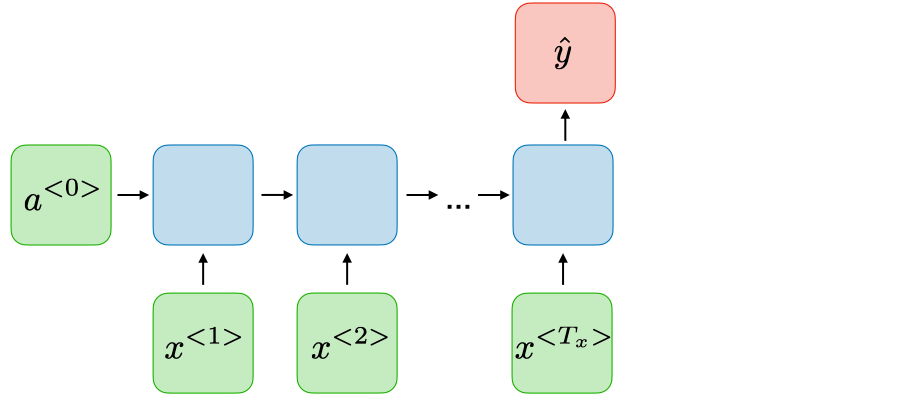

#### Pues es justamente lo que se busca:

#### Se tiene un conjunto de palabras <b> X_1 .... X_n </b> y por medio de una función de activación <b>A</b>, se genera una salida <b>Y</b>, que en este caso es precisamente lo que proporcionaría el "sentimiento" (positivo o negativo).

#### De esta manera se simula la arquitectura comentada; para valores más concretos se usa la siguiente sección.

## 2.3 Implementación y Entrenamiento de la Red Neuronal Recurrente para Sentiment Classification

#### En esta etapa se implementan las capas de la red neuronal y se explican algunos valores colocados.

#### Los sitios de los que se ha tomado la información para complementar la impementación son:

* # https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419

* # https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

* # https://medium.com/nlplanet/text-similarity-with-the-next-generation-of-word-embeddings-in-gensim-466fdafa4423

In [ ]:
#Para inicializar los pesos de la red.
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
#Aquí se explican todas las capas con sus parámetros:

# Capa Input
#Esta es la entrada, aquí sólo se necesita que se tenga el parámetro
#equivalente al máximo número de la oración que se definió previamente.
input = Input(shape = (max_pad_sequence,))

#------------------------------------------------------------------------------

# Capa de Embedding
#En esta capa se tiene
# -> num_tokens - número de palabras únicas de nuestro conjunto de
#entrenamiento
# -> output_dim - numero de dimensiones del modelo (ya dado por word2vec).
# -> embedding matrix - la matriz que se creó previamente sin las palabras.
# Importante que se ponga el valor trainable a False porque ya se le da un modelo
# entrenado (word2vec.)
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)

#------------------------------------------------------------------------------

#Capa 1 - LSTM UNidireccional

#Aquí básicamente la propuesta es que se mantenga todo simple y por eso la capa
#LSTM NO es bidireccional y no tiene ni return_sequences ni recurrent_dropout.
#Lo que se preserva es el dropout que es parte del requisito del examen.
LSTM_Single = LSTM(units = 128,
                   #return_sequences = True, # Todos los estados h para cada timestep
                   #recurrent_dropout = 0.2,
                   dropout = dropout_value # Para evitar sobreajuste (parte del requisito del ejercicio.)
                   )(embedding)

#------------------------------------------------------------------------------

#Capa de Salida

#Siendo esta la última capa, sólo necesitamos que tenga una dimensión de salida y cuya función
#de activación sea SIGMOIDE ya que, de acuerdo al siguiente sitio:

#https://datascience.stackexchange.com/questions/56830/what-are-the-best-activation-functions-for-binary-text-classification-in-neural

#Es la mejor opción para una clasificación de sentimiento.

out = Dense(1,                    # dimensiones de salida (sólo se necesita una cuyos valores son 0 o 1)
            activation="sigmoid"  # para obtener una probabilidad para cada clase
                                  # función de activación
                                  # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          )(LSTM_Single)

#------------------------------------------------------------------------------

#Se genera el modelo y se imprime un resumen del mismo.
sentiment_classification_model = Model(input, out)  # unión del modelo
sentiment_classification_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227)]             0         
                                                                 
 embedding (Embedding)       (None, 227, 300)          20491800  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20711577 (79.01 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 20491800 (78.17 MB)
_________________________________________________________________


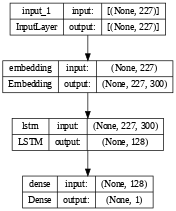

In [ ]:
#Se hace una impresión gráfica de la arquitectura.

plot_model(
           sentiment_classification_model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir="TD",
           dpi=50,
)

Ahora, se compila y se entrena la RNN:

In [ ]:
#Se compila el modelo:

#Por cuestiones de tiempo, se dejan los mismos parámetros que en clase pero algo que sí
#se pudo constantar es que la función de pérdida debe cambiar a

#"binary_crossentropy"

#dado que la salida es binaria ahora:
#https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

#De acuerdo a este sitio, el optimizador ADAM es el correcto para este tipo de
#algoritmos:

#https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419


sentiment_classification_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                                                 # adam: stochastic gradient descent adaptativo
                                                                 # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                                       loss="binary_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                                 # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                                       metrics=['accuracy'])

In [ ]:
#Se entrena el modelo.
#Por falta de tiempo los parámetros se dejan igual que los vistos en clase.
history = sentiment_classification_model.fit(X_train, y_train,
                                             validation_split=0.2,
                                             batch_size=2000,
                                             epochs=5,   # número de iteraciones sobre los datos
                                             verbose=1)

Epoch 1/5
234/234 [==============================] - 3201s 14s/step - loss: 0.1911 - accuracy: 0.9280 - val_loss: 0.1441 - val_accuracy: 0.9509
Epoch 2/5
234/234 [==============================] - 3178s 14s/step - loss: 0.1380 - accuracy: 0.9521 - val_loss: 0.1303 - val_accuracy: 0.9551
Epoch 3/5
234/234 [==============================] - 3182s 14s/step - loss: 0.1227 - accuracy: 0.9581 - val_loss: 0.1168 - val_accuracy: 0.9605
Epoch 4/5
234/234 [==============================] - 3177s 14s/step - loss: 0.1142 - accuracy: 0.9614 - val_loss: 0.1128 - val_accuracy: 0.9624
Epoch 5/5
234/234 [==============================] - 3133s 13s/step - loss: 0.1085 - accuracy: 0.9634 - val_loss: 0.1107 - val_accuracy: 0.9631


In [ ]:
#Se guarda todo el modelo:
#https://www.tensorflow.org/tutorials/keras/save_and_load

sentiment_classification_model.save_weights(google_drive_path + "/MyDrive/" + reviews_file_path + neural_network_weights_file_name)

## 2.4 Predicción y Evaluación de la Red Neuronal Recurrente para Sentiment Classification

#### En esta sección se llevan a cabo las evaluaciones del modelo así como las métricas.

#### Para este caso se han ocupado tanto el score mismo como la matriz de confusión.

In [ ]:
#Se lee el modelo guardado (descoméntese todo):
#sentiment_classification_model.load_weights(google_drive_path + "/MyDrive/" + neural_network_weights_file_name)

#El modelo se debe compilar nuevamente.
sentiment_classification_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                                                 # adam: stochastic gradient descent adaptativo
                                                                 # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                                       loss="binary_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                                 # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                                       metrics=['accuracy'])

In [ ]:
#Se calcula la precisión del modelo.
scores = sentiment_classification_model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#------ RESULTADO --------
#El modelo tiene una precisión alta.

4568/4568 [==============================] - 606s 133ms/step - loss: 0.1064 - accuracy: 0.9644
Test accuracy: 0.9644393920898438


In [ ]:
#Para completar el ejercicio, se hace una prueba con textos nuevos.
dictionary_of_tests = {
                        'text': ['My experience was cool. The animation and the graphics were out of this world. I would recommend this place.',
                                 'I am never returning to this place, it sucks',
                                 'I would say that in general I had a pleasant experience, I liked the attention but disliked the food.',
                                 'I liked your hospitality, youre the best guests in the world'
                                 ]
}


#Generando el tratamiento de conversión a tokens y números para cada uno de los
#textos.
test_df = pd.DataFrame(dictionary_of_tests)

test_df["text"] = test_df["text"].apply(lambda x: transform_review(x))
test_df["text"] = test_df["text"].apply(lambda x: transform_words_to_index(x))
test_df= pad_sequences(test_df["text"], padding='pre', maxlen = max_pad_sequence)


predictions = sentiment_classification_model.predict(test_df,verbose=1)

print("Las predicciones de cada texto respectivamente: ", predictions)

#------ RESULTADO --------
#De acuerdo con los análisis, se puede alcanzar a ver que de manera cualitativa,
#la puntuación coincide con el tipo de "sentimiento" en cada una de las pruebas,
#por lo que el modelo sí nos está ayudando a clasificar correctamente.

1/1 [==============================] - 1s 581ms/step
Las predicciones de cada texto respectivamente:  [[0.9952975 ]
 [0.38935173]
 [0.3172228 ]
 [0.9874978 ]]


In [ ]:
# A continuación se calcula la matriz de confusión del modelo.

#Se le da un tratamiento a los y_test.
y_test_copy = y_test.copy()
y_test_copy = np.where(y_test_copy > 0.5, 1,0)

print("Y_test: ", y_test_copy)
print("")

#Se obtienen las predicciones y se les da un tratamiento para poder
#ser comparadas.
y_pred = sentiment_classification_model.predict(X_test,verbose=1)
y_pred_copy = y_pred.copy()

#Para que quede en forma de un simple array.
y_pred_copy = y_pred_copy.reshape(-1)
y_pred_copy = np.where(y_pred_copy > 0.5, 1,0)

print("Y_pred: ", y_pred_copy)

print("")
print("La matriz de confusión es: " )
print("")
confusion_matrix(y_test_copy,y_pred_copy)


#------ RESULTADO --------
#De acuerdo con el resultado, el modelo nos estaría dado muy pocos falsos
#positivos (6) y falsos negativos (18), lo cual refuerza la idea de que se ha obtenido
# una solución muy robusta.